# Building neural networks with PyTorch

i

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import torch # import the PyTorch package
import torchvision # import trochvision package

## PyTorch Tensors - enhanced NumPy arrays

In [7]:
v = torch.Tensor([1, 2, 3])

In [5]:
v

tensor([ 1.,  2.,  3.])

In [6]:
v[0]

tensor(1.)

### Why PyTorch Tensors?

* Tensors can be run on **GPUs**

In [8]:
from torch import nn
import torch.nn.functional as F

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# Get the data

We are going to load a **training set** that we are going to use to train our network and a separate **test set** that we'll use to evaluate the performance of the network.

## Loading the training set

We can use convenience methods in `torchvision.datasets` to download various popular machine learning benchmark images. Here we are going to download [**MNIST**](http://yann.lecun.com/exdb/mnist/) which is a collection of handwritten digits along with labels (i.e. what digit was drawn).

The MNIST dataset consists of a total of 70,000 images, of which 60,000 are desginated as the **training set** and 10,000 are designated as the **test set**. This standardized separation allows everyone around the world to evaluate and compare their model's performances with each other!

In [42]:
train_set = torchvision.datasets.MNIST('./data', train=True, download=True)

This returns Torchvision's special **dataset** object that can be used to represent **supervised datasets** consisting of both inputs (i.e. images) and targets (i.e. digit labels).

In [43]:
len(train_set)

60000

In [50]:
image, label = train_set[100]

Text(0.5,1,'Digit: 5')

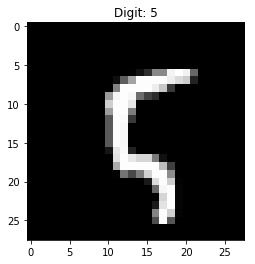

In [51]:
plt.imshow(image)
plt.title('Digit: {}'.format(label))

## Loading the test set

You can get the test set in an identical fashion, passing in `train=False` into `MNIST`:

In [45]:
test_set = torchvision.datasets.MNIST('./data', train=False, download=True)

In [46]:
len(test_set)

10000

In [52]:
image, label = train_set[3]

Text(0.5,1,'Digit: 1')

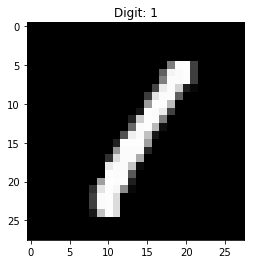

In [53]:
plt.imshow(image)
plt.title('Digit: {}'.format(label))

## Add data transforms

Even before you start feeding in your images into a neural network, it is very common to perform some data transformations - modifying images in some fixed manner that makes it easier to work with them.

One of the most common image transformation is **normalization**, where you first compute mean and standard deviation across all images (typically in the training set). You then subtract the mean from each image and also divide each image by the standard deviation. If you did this, and recomputed the mean and standard deviation across all images, you will find that they now have **mean of 0** and **standard deviation of 1**, and thus they are said to be **normalized**.

Normalization helps ensure input image intensities stay within some expected range, allowing the network to not have to worry about large variations in image values that is otherwise visually uninteresting.

Also, when you load images from Torchvision, they are provided as Pillow package's Image object. Pillow is one of Python's popular image processing package, and there images are represented by a dedicated Image object with a lot of methods implementing common image processing operations.

However, in PyTorch, networks only understands PyTorch Tensors, and thus we must convert the images from Pillow Image into PyTorch Tensor before we can pass the image into the network.

We can achieve these two *transformations* by making use of Torchvision's transformation operations. You combine multiple transformation operations together and pass it at the time of dataset loading. This returns a dataset that **applies these transformations** automatically on all images! 

Let's add a transformation that will:
1. convert images into PyTorch tensors
2. normalize the images against the mean of 0.1307 and standard deviation of 0.3081.

In [56]:
from torchvision import transforms # get torchvision's transforms subpackage

In [57]:
# create a composite transform that first converts images to tensors and then normalize the images
image_transform = transforms.Compose([
    transforms.ToTensor(), # converts images into Tensors
    transforms.Normalize([0.1307], [0.3081])
])

# apply the transforms at the time of dataset loading
training_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                          transform=image_transform)
test_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                          transform=image_transform)

Now any image you access through the dataset has the transformation already applied

# Defining your network

In PyTorch, you define a new neural network by defining a **new class that inherits from nn.Module** as follows:

In [68]:
class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 10)
        
    def forward(self, x):
        return self.fc1(x)

To understand this better, let's take a quick review of classes and learn the new concept of **object inheritance**.

## Defining a class

In the past session, we have taken a look at defining a **class** to represent a grouping of data and functions, where each **instance of a class** or **object** can be thought of as representing a concrete unit that has **properties** and **behavior** (or **methods**).

In [160]:
class Person:
    def __init__(self, name):
        self.name = name  # assign name
        
    def title(self):
        return "an ordinary person."
    
    def greeting(self):
        print('Hello! My name is {}.'.format(self.name))
        print("I'm {}".format(self.title()))

In [161]:
edgar = Person('Edgar')
john = Person('John')

In [162]:
edgar.greeting()

Hello! My name is Edgar.
I'm an ordinary person.


In [164]:
john.greeting()

Hello! My name is John.
I'm an ordinary person.


Here you can see that both `edgar` and `john` are objects of type (class) `Person`. They both have properties called `name` that is unique to each, and have the common behaviors (method) called `greeting` that prints out a greeting message introducing themselves. Note that `greeting` method calls another method `title` in creating the intro statement.

Key of Object-Oriented Programming (OOP) is to group certain data (e.g. `name`) with behavior (e.g. `greeting`, `title`) that when put together can be used to represent a conceptual grouping that may correspond to some real world *objects*.

## Specialization via inheritance

Now imagine that you want to define a new **class** of object called `Scientist` that has everything that a `Person`  has (e.g.`name`, `greeting`, and `title`), but has extra property called `topic` that specified their research topic, and has a new behavior (i.e. *method*) called `research` that finds a significant result at p-value < 0.05. 

Without worry much about code duplication, you could implement it as such: 

In [165]:
import random

class Scientist:
    def __init__(self, name, topic):
        self.name = name
        self.topic = topic
        
    def title(self):
        return "an ordinary person."
    
    def greeting(self):
        print('Hello! My name is {}.'.format(self.name))
        print("I'm {}".format(self.title()))
 
    def research(self, silent=False):
        print('Performing a research on the topic {}...'.format(self.topic))
        pvalue = random.random() # randomly pick a value between [0, 1)
        
        if pvalue < 0.05:
            if not silent:
                print('Results statistically significant with p-value={:0.3f}!! Publish!!'.format(pvalue))
            return True
        else:
            if not silent:
                print('Results was not significant with p-value={:0.3f}... Continue working...'.format(pvalue))
            return False

In [166]:
edgar = Scientist(name='Edgar', topic='computational neuroscience')

In [167]:
edgar.greeting()

Hello! My name is Edgar.
I'm an ordinary person.


In [168]:
edgar.research()

Performing a research on the topic computational neuroscience...
Results was not significant with p-value=0.793... Continue working...


False

Now notice that there is a lot of repeated code between a `Person` and a `Scientist`. Both has property called `name` and a method called `greeting`. After all, a Scientist **is a** Person, right? When one class can be thought of as a **specialization** of another class, you can save alot of typing and code duplication by using **class inheritance**!

In [169]:
import random

class Scientist(Person):  # Scientist inherits from Person
    def __init__(self, name, topic):
        super().__init__(name)
        self.topic = topic

    def research(self, silent=False):
        print('Performing a research on the topic {}...'.format(self.topic))
        pvalue = random.random() # randomly pick a value between [0, 1)
        
        if pvalue < 0.05:
            if not silent:
                print('Results statistically significant with p-value={:0.3f}!! Publish!!'.format(pvalue))
            return True
        else:
            if not silent:
                print('Results was not significant with p-value={:0.3f}... Continue working...'.format(pvalue))
            return False

In [170]:
moku = Scientist(name='Moku', topic='physics')

In [171]:
edgar.greeting()

Hello! My name is Edgar.
I'm an ordinary person.


In [172]:
edgar.research()

Performing a research on the topic computational neuroscience...
Results statistically significant with p-value=0.048!! Publish!!


True

Notice that the `Scientist` class no longer implements the `greeting` and `eat` methods, yet you can still call them on the instance of `Scientist`. This is because these methods were **inherited** from `Person` class.

Furthermore, we call something funny inside the `__init__` method: `super().__init__(name)`. As you may be able to guess, this calls the initializer of `Person` or the **super class**, passing in the value it expects (e.g. `name` of the person). This allows any complex configuration that `Person` might have done in its `__init__` to be reused.

Finally, you can **override** super class's implementation of a method to give a new, specialized behavior to an existing method! Here, let's **override** the implementation of the method `title`, in effect cusotmizing the introduction:

In [175]:
import random

class Scientist(Person):  # Scientist inherits from Person
    def __init__(self, name, topic):
        super().__init__(name)
        self.topic = topic
        
    # overriding title method
    def title(self):
        return "a scentist in {}".format(self.topic)

    def research(self, silent=False):
        print('Performing a research on the topic {}...'.format(self.topic))
        pvalue = random.random() # randomly pick a value between [0, 1)
        
        if pvalue < 0.05:
            if not silent:
                print('Results statistically significant with p-value={:0.3f}!! Publish!!'.format(pvalue))
            return True
        else:
            if not silent:
                print('Results was not significant with p-value={:0.3f}... Continue working...'.format(pvalue))
            return False

In [176]:
edgar = Scientist(name='Edgar', topic='computational neuroscience')

In [177]:
edgar.greeting()

Hello! My name is Edgar.
I'm a scentist in computational neuroscience


You can see that we were able to modify the behaivor of an already existing method `greeting` by overriding the behavior of the another method `title`. This pattern in which you can **customize** behavior of an already existing mechanism by overriding another method happens quite commonly. In fact, we will soon encounter them in implementing our neural network in PyTorch!!

## Networks inherit from *nn.Module*

Now armed with knowlege of class inheritance, let's take another look at a typical definition of a neural network in PyTorch. In PyTorch, any network **is a** `nn.Module`. In other words, you define a new class that inherits from `nn.Module`.

In [187]:
class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(5, 10)
        
    def forward(self, x):
        y = self.fc(x)
        z = F.relu(y)
        return z

Above, we can see that `MyNetwork` *inherits from* `nn.Module`. This gives our class `MyNetwork` with a lot of properties and methods that is already part of `nn.Module`, and this is precisely what allows you to define a new neural network with minimal work. 

A network in PyTorch (which is a class), typically consists of one or more **layers** that you create and hold on to inside the `__init__` method. Here, we are defining a single `nn.Linear` layer which corresponds to a *fully-connected* linear layer connecting from 5 input nodes into 10 output nodes. We **instantiate** this layer and assign it to the object's property named `fc` (standing for **f**ully **c**onnected layer).

Note that in the `__init__`, we have not computed anything. We simply instantiated a layer and assigned it to a property for *later use*.

Real use of a PyTorch module comes in when you **instantiate** the class - that is, you create an object:

In [188]:
net = MyNetwork()

This action just created a new **instance** of the network, with it's own network weights that can be trained!

A key feature of a module is the fact that you can use it like a function - it accepts an input and returns an output!

In [189]:
x = torch.rand(1, 5) # a simple vector of 5 elements - or 5 input values

y = net(x) # you use a module instance like a function!

y

tensor([[ 0.0695,  0.4837,  0.0000,  0.0000,  0.2656,  0.0000,  0.0172,
          0.0000,  0.3369,  0.0000]])

In [186]:
y.shape

torch.Size([1, 10])

The secret behind this is the `forward` method we defined in the `MyNetwork` class:

```python
 def forward(self, x):
    y = self.fc(x)
    z = F.relu(y)
    return z
```

In this method, we accepted a parameter `x`, and we used the fully-connected linear layer `self.fc` as a function with `x` as the input!

It turns out that `nn.Linear` is yet another **subclass** of `nn.Module` and thus can take input, return output. Our particular `self.fc` was configured to take in input of size 5 and output vector of size 10.

The `F.relu` is then an element-wise operation that clips any value less than 0 to 0, while keeping positive values as is. `forward` function finally returns the output of `relu` and that becomes the output of the whole network.

All in all, `MyNetwork` implemented a **single full-connected layer neural network with ReLU output non-linearity** - one of the simplest networks you can construct!

## Building network to classify images into digits 

Now we have seen how to build a network by defining a new class that inherits from `nn.Module`, let's try to implement a network that takes in a $28 \times 28$ pixels gray scale image of a digit and classifies them into 1 of 10 digits!

The input will be one or more images of size $28 \times 28$, and we are going to set **the output to be a vector of size 10** where each position indicates a *log probability* that the image belongs to the specific digit.

We'll start with a simplest possible implementation where we **flatten out** the input image into a vector of size 28 * 28 = 784. This will be **fully connected neural network with no output nonlinearity** linking 784 input nodes into 10 output nodes.

In [199]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # flattens an image of form N x 1 x 28 x 28 -> N x 784
        x = self.fc(x)
        x = F.log_softmax(x, dim=1) # make sure that probabilities add up to one, and then take log
        return x

And that's it!

Let's instantiate the network and run an image through it:

In [200]:
net = SimpleNetwork()

In [201]:
image, label = test_set[30]

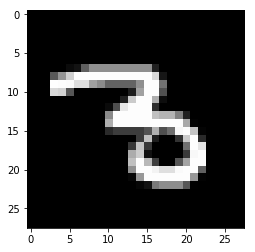

In [210]:
plt.imshow(image.squeeze(), cmap='gray')

In [209]:
net(image)

tensor([[-1.9762, -2.1093, -2.4735, -2.6918, -3.4270, -3.2984, -1.9790,
         -2.4868, -1.4873, -2.6417]])

This is a log of class probabilities, so we can exponentiate this to get the actual probability over classes:

In [203]:
torch.exp(net(image))

tensor([[ 0.1386,  0.1213,  0.0843,  0.0678,  0.0325,  0.0369,  0.1382,
          0.0832,  0.2260,  0.0712]])

We can perhaps take the index with the largest probability as the network's best guess:

In [205]:
p = torch.exp(net(image))
torch.argmax(p)

tensor(8)

But the label is:

In [206]:
label

tensor(3)

So you can see that our network is not quite performing well. That's expected because our network is **randomly initialized**! In order to get a reasonable performance, we need to **train** the network!

# Training a neural network

We are going to **train our network** by minimizing a **loss function** - a function that evaluates how *off* we are from the true target of the world. Chosing a good loss function can influence how well your network performs. In the case of **N-way classification** problem where the output is a vector of size *N*, it's quite common to treat the output as the log probability of N classes, and optimize the network by miniminzg **negative log likelihood**. This is akin to adjusting the network weights so that the correct class would have the higest probability.

When training a network we will also 

From

In [190]:
28 * 28

784

In [169]:
import random

class Scientist(Person):  # Scientist inherits from Person
    def __init__(self, name, topic):
        super().__init__(name)
        self.topic = topic

    def research(self, silent=False):
        print('Performing a research on the topic {}...'.format(self.topic))
        pvalue = random.random() # randomly pick a value between [0, 1)
        
        if pvalue < 0.05:
            if not silent:
                print('Results statistically significant with p-value={:0.3f}!! Publish!!'.format(pvalue))
            return True
        else:
            if not silent:
                print('Results was not significant with p-value={:0.3f}... Continue working...'.format(pvalue))
            return False

In [59]:
type(image)

torch.Tensor

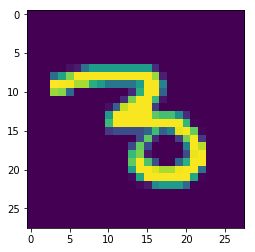

In [60]:
plt.imshow(image.squeeze())

In [ ]:
# Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)




In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)